# 사진 준비

In [1]:
import os
import urllib # 웹에서 데이터를 다운로드할 때 사용
import cv2 # 이미지 처리를 위해 필요
import numpy as np

from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

print('complete')

complete


person shape (590, 590, 3)
cat shape (720, 720, 3)
dog shape (2927, 2927, 3)


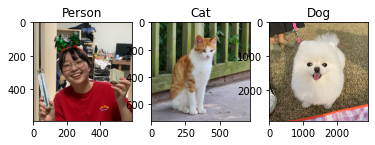

In [2]:
# 준비한 이미지 읽기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_image.png'
cat_orig = cv2.imread(cat_path)

dog_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog_image.png'
dog_orig = cv2.imread(dog_path)

print('person shape', img_orig.shape)
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
ax.set_title('Person')

print('cat shape', cat_orig.shape)
ax = plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
ax.set_title('Cat')

print('dog shape', dog_orig.shape)
ax = plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(dog_orig, cv2.COLOR_BGR2RGB))
ax.set_title('Dog')

plt.show()

# 시맨틱 세그멘테이션 다뤄보기

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f199f5a4e80>)

PixelLib에서 제공해 주는 모델을 다운로드

## Person

### 인물 마스킹

In [4]:
# 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
# PASCAL VOC데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있다.

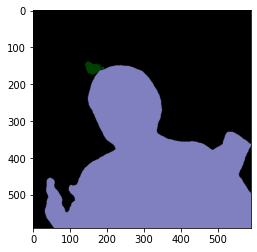

In [7]:
# 세그멘테이션 된 결과가 각각 다른 색상으로 담겨있다.
plt.imshow(output)
plt.show()

In [8]:
# 어떤 물체가 있는지 알 수 있다.
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


In [9]:
# 물체마다 output에 어떤 색상으로 나타나 있는지 확인한다.
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [10]:
# 추출해야 할 '사람'에 해당하는 색상은 무엇인지 확인한다.
colormap[15] # label name에서 'person'이 15번째에 해당

array([192, 128, 128])

In [11]:
# output이미지는 BGR순서로 채널 배치가 되어있고, colormap은 RGB 순서이므로 순서를 바꿔줘야 한다.
seg_color = (128,128,192)

(590, 590)


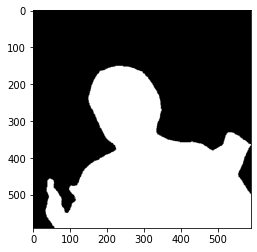

In [12]:
# seg_color로만 이루어진 마스크 생성
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

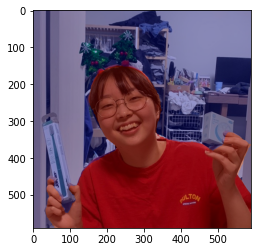

In [13]:
# 원본 이미지와 인물을 마스킹한 이미지를 겹쳐 보며 세그멘테이션이 잘 되었는지 확인
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 만들기

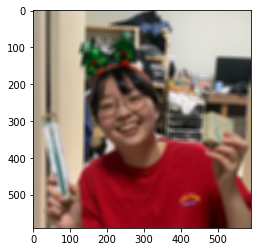

In [14]:
# 배경 블러 처리
img_orig_blur = cv2.blur(img_orig, (13,13)) # (13,13) blurring kernel size
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

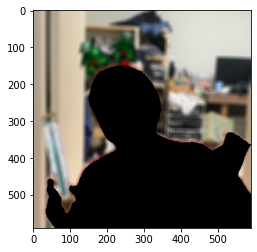

In [15]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전, 배경은 255 사람은 0이 된다.
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 배경만 있는 이미지를 얻는다.
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경과 인물 이미지 합성

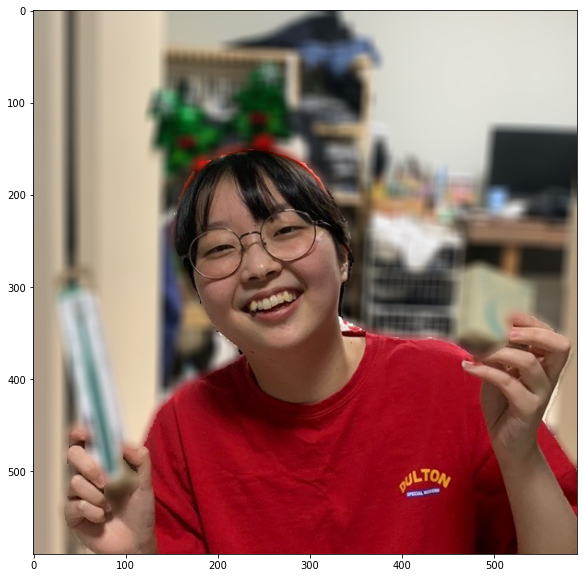

In [16]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

fig = plt.figure(figsize=(10, 10)) # 결과를 꼼꼼히 확인하기 위해 화면에 커다랗게 출력

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

In [17]:
person_result = img_concat
cv2.imwrite('person_result.png', person_result)

True

문제점 지적을 위해, 결과 이미지를 다운로드

## Cat

### 고양이 마스킹

In [18]:
# 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [19]:
# 모델에 이미지 입력
cat_segvalues, cat_output = model.segmentAsPascalvoc(cat_path)

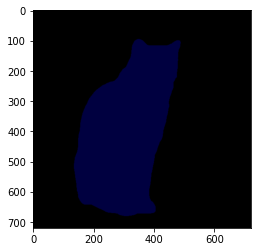

In [20]:
# 세그멘테이션 된 결과가 각각 다른 색상으로 담겨있다.
plt.imshow(cat_output)
plt.show()

In [21]:
# 어떤 물체가 있는지 알 수 있다.
for class_id in cat_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [22]:
# 추출해야 할 '사람'에 해당하는 색상은 무엇인지 확인한다.
colormap[8] # label name에서 'cat'이 8번째에 해당

array([64,  0,  0])

In [23]:
# output이미지는 BGR순서로 채널 배치가 되어있고, colormap은 RGB 순서이므로 순서를 바꿔줘야 한다.
cat_seg_color = (0,0,64)

(720, 720)


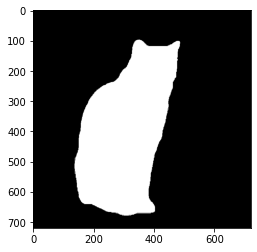

In [24]:
# seg_color로만 이루어진 마스크 생성
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
cat_seg_map = np.all(cat_output==cat_seg_color, axis=-1)
print(cat_seg_map.shape)
plt.imshow(cat_seg_map, cmap='gray')
plt.show()

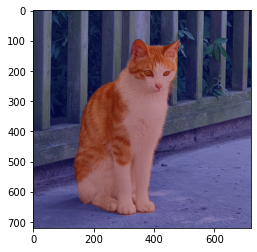

In [25]:
# 원본 이미지와 인물을 마스킹한 이미지를 겹쳐 보며 세그멘테이션이 잘 되었는지 확인
cat_show = cat_orig.copy()

cat_mask = cat_seg_map.astype(np.uint8) * 255

cat_color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)

cat_show = cv2.addWeighted(cat_show, 0.6, cat_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 만들기

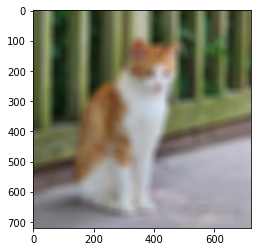

In [26]:
# 배경 블러 처리
cat_orig_blur = cv2.blur(cat_orig, (30,30))
plt.imshow(cv2.cvtColor(cat_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

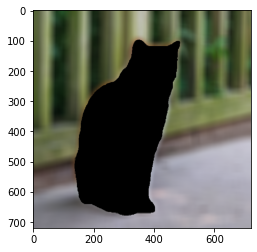

In [27]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
cat_mask_color = cv2.cvtColor(cat_mask, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg_blur = cv2.bitwise_and(cat_orig_blur, cat_bg_mask)
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경과 고양이 이미지 합성

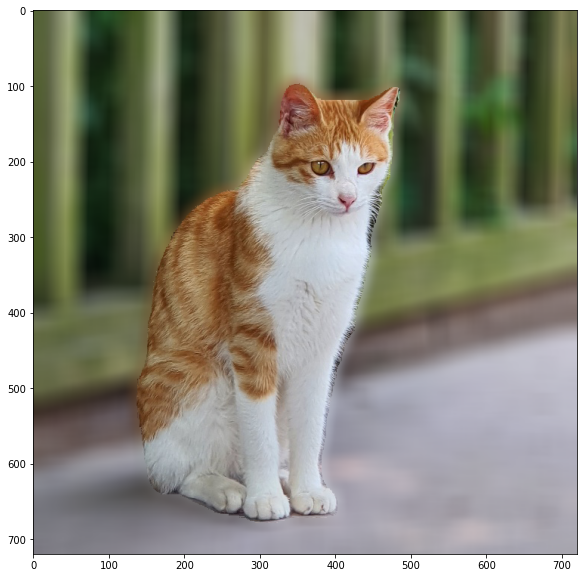

In [28]:
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)

fig = plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))

In [29]:
cat_result = cat_concat
cv2.imwrite('cat_result.png', cat_result)

True

## Dog

### 강아지 마스킹

In [30]:
# 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [31]:
# 모델에 이미지 입력
dog_segvalues, dog_output = model.segmentAsPascalvoc(dog_path)

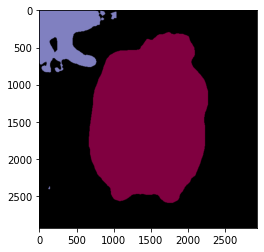

In [32]:
# 세그멘테이션 된 결과가 각각 다른 색상으로 담겨있다.
plt.imshow(dog_output)
plt.show()

In [33]:
# 어떤 물체가 있는지 알 수 있다.
for class_id in dog_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog
person


In [34]:
# 추출해야 할 '사람'에 해당하는 색상은 무엇인지 확인한다.
colormap[12] # label name에서 'dog'이 12번째에 해당

array([ 64,   0, 128])

In [35]:
# output이미지는 BGR순서로 채널 배치가 되어있고, colormap은 RGB 순서이므로 순서를 바꿔줘야 한다.
dog_seg_color = (128,0,64)

(2927, 2927)


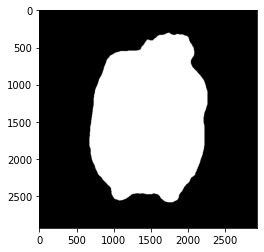

In [36]:
# seg_color로만 이루어진 마스크 생성
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
dog_seg_map = np.all(dog_output==dog_seg_color, axis=-1)
print(dog_seg_map.shape)
plt.imshow(dog_seg_map, cmap='gray')
plt.show()

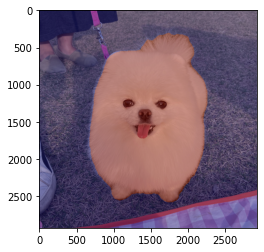

In [37]:
# 원본 이미지와 인물을 마스킹한 이미지를 겹쳐 보며 세그멘테이션이 잘 되었는지 확인
dog_show = dog_orig.copy()

dog_mask = dog_seg_map.astype(np.uint8) * 255

dog_color_mask = cv2.applyColorMap(dog_mask, cv2.COLORMAP_JET)

dog_show = cv2.addWeighted(dog_show, 0.6, dog_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(dog_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 만들기

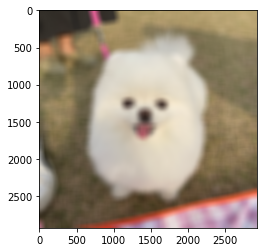

In [38]:
# 배경 블러 처리
dog_orig_blur = cv2.blur(dog_orig, (100,100))
plt.imshow(cv2.cvtColor(dog_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

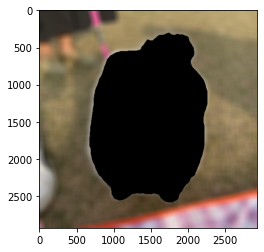

In [39]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
dog_mask_color = cv2.cvtColor(dog_mask, cv2.COLOR_GRAY2BGR)
dog_bg_mask = cv2.bitwise_not(dog_mask_color)
dog_bg_blur = cv2.bitwise_and(dog_orig_blur, dog_bg_mask)
plt.imshow(cv2.cvtColor(dog_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경과 강아지 이미지 합성

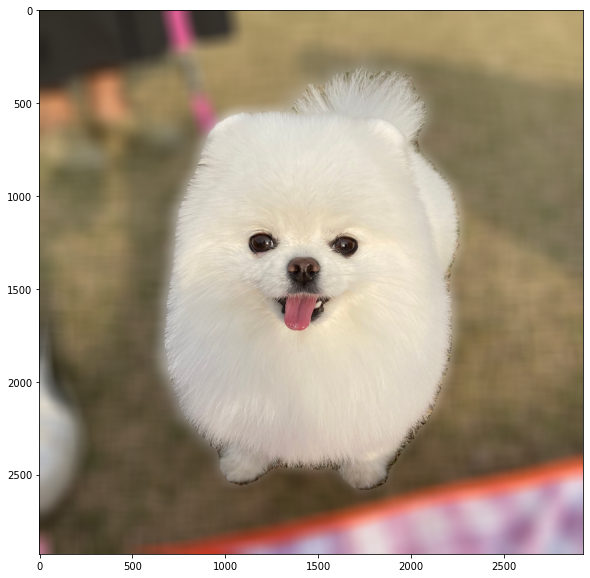

In [40]:
dog_concat = np.where(dog_mask_color==255, dog_orig, dog_bg_blur)

fig = plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(dog_concat, cv2.COLOR_BGR2RGB))

In [41]:
dog_result = dog_concat
cv2.imwrite('dog_result.png', dog_result)

True

# 크로마키 배경 합성

background image shape (1440, 1080, 3)
background image 2 shape (1000, 1333, 3)


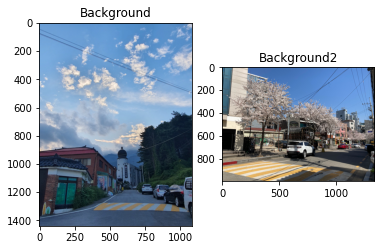

In [42]:
# 배경 사진 불러오기
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg.png'  
bg = cv2.imread(bg_path)

bgt_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg2.png'  
bgt = cv2.imread(bgt_path) 

print('background image shape', bg.shape)
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))
ax.set_title('Background')

print('background image 2 shape', bgt.shape)
ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(bgt, cv2.COLOR_BGR2RGB))
ax.set_title('Background2')

plt.show()

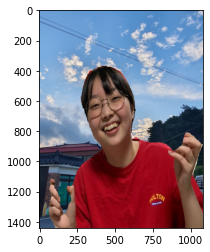

In [70]:
img_resized = cv2.resize(img_orig, (bg.shape[1], bg.shape[0]))
img_mask_resized = cv2.resize(img_mask_color, (bg.shape[1], bg.shape[0]))

img_bg_concat = np.where(img_mask_resized == 255, img_resized, bg)

plt.imshow(cv2.cvtColor(img_bg_concat, cv2.COLOR_BGR2RGB))
plt.show()

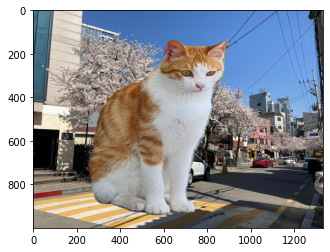

In [71]:
cat_resized = cv2.resize(cat_orig, (bgt.shape[1], bgt.shape[0]))
cat_mask_resized = cv2.resize(cat_mask_color, (bgt.shape[1], bgt.shape[0]))

cat_bg_concat = np.where(cat_mask_resized == 255, cat_resized, bgt)

plt.imshow(cv2.cvtColor(cat_bg_concat, cv2.COLOR_BGR2RGB))
plt.show()

배경 이미지 사이즈에 맞춰 피사체 크기를 resize하느라 원본에서 비율이 살짝 달라졌지만, 크로마키가 제대로 되었음을 확인했다.

# 사진에서 문제점 찾기

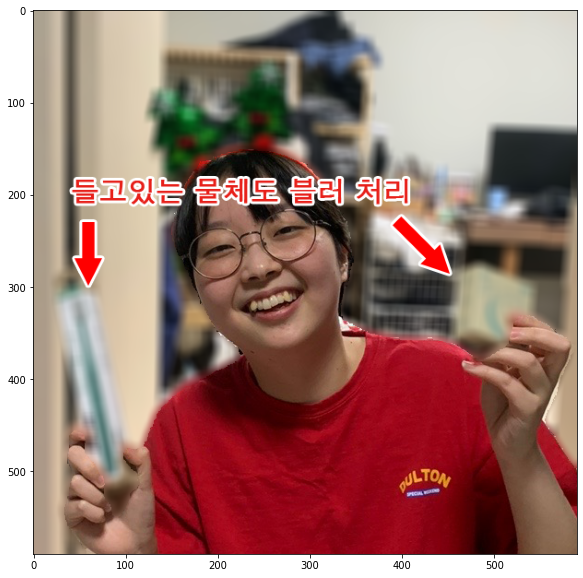

In [72]:
problem_path = os.getenv('HOME')+'/aiffel/human_segmentation/person_result.png'  
problem = cv2.imread(problem_path)

fig = plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(problem, cv2.COLOR_BGR2RGB))

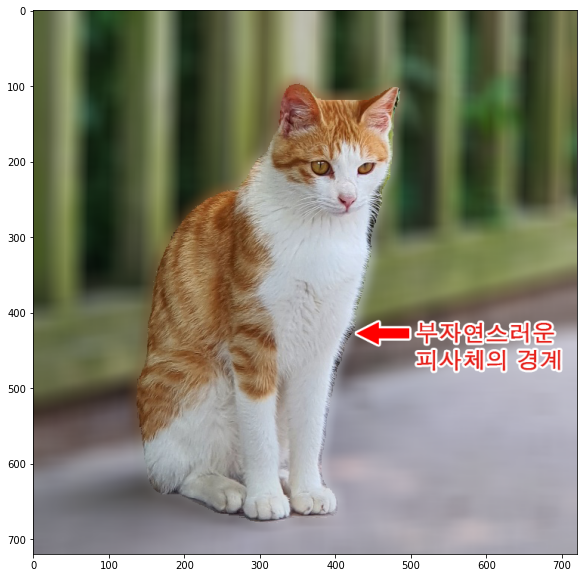

In [73]:
problem2_path = os.getenv('HOME')+'/aiffel/human_segmentation/cat_result.png'  
problem2 = cv2.imread(problem2_path)

fig = plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(problem2, cv2.COLOR_BGR2RGB))

# 해결 방법 제안

### 들고있는 물체도 블러 처리

후천적으로 '인물', '고양이', '강아지'등의 학습된 이미지로 데이터를 구별해 피사체를 분리하려니 카메라로부터 같은 거리에 있음에도 사람 손에 쥔 물체까지 배경마냥 블러 처리 되어버렸다.   
이는 사진을 촬영하는 시점에서 '물체 간 거리'를 기준으로 카테고라이징한 정보를 얻을 수 있도록 하면 해결할 수 있다.   
노드에서 말하는 3D이미지 센서나 struct2depth 기술을 사용할 수 있겠다.   
아이폰, 아이패드에서 3D이미지 센서를 'Lidar센서'라는 이름으로 탑재해 출시하고 있으므로 이를 이용해봐도 좋겠다는 생각이 든다.

### 부자연스러운 피사체의 경계

흔히 포토샵에서 이미지를 합성할 때 쓰던 방법으로, 배경 뿐만 아니라 '마스킹한 피사체의 경계'도 살짝 흐리게 만든다.   
이 때 무작정 또렷하지 않도록 흐리기만 하면 되는 배경과 달리 시선이 집중되는 사진의 "주제부"로서 퀄리티가 나와야 하므로, 평균값 블러(cv2.blur)가 아닌 가우시안 블러(cv2.GaussianBlur)를 사용한다.

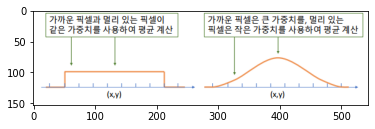

In [74]:
blur_path = os.getenv('HOME')+'/aiffel/human_segmentation/blur.png'  
blur = cv2.imread(blur_path)

plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))            

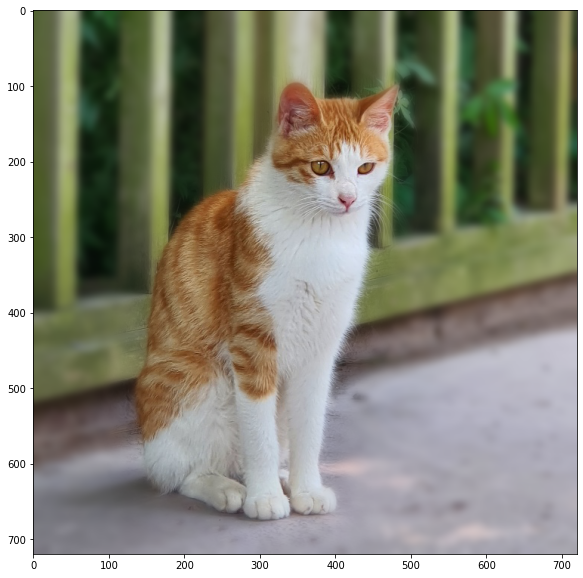

In [75]:
# 채널을 3 channel로 바꾼다.
cat_mask_3 = np.repeat(np.expand_dims(cat_mask, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
cat_orig_blur = cv2.GaussianBlur(cat_orig, (31 ,31),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
cat_mask_g = (cv2.GaussianBlur(cat_mask_3, (99, 99), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
cat_image_blur = cat_mask_g*cat_orig.astype(np.float32)
cat_bg_mask = (1-cat_mask_g)*cat_orig_blur.astype(np.float32) # 1 - cat_mask_g = 배경 영역
result = (cat_image_blur+cat_bg_mask).astype(np.uint8)

fig = plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

피사체의 경계를 흐리니 예상대로 자연스럽게 합성되었다.

# 회고

문제점을 찾고, 해결방법을 제안하고, 해결방법을 구현까지 해야하는 줄 알고 이번 과제를 확인했을 때 크게 겁을 먹었었다. 하지만 조원분들과 문제점 찾기&해결방법에 대한 토론 중 구현은 하지 않아도 된다는 걸 알아채 다행이고, 이전에 이미지 합성을 해 본적이 자주 있었기 때문에 문제점을 찾고 해결방법을 제시하는 데 도움을 드려 뿌듯했다(누끼를 대충 따서 가우시안 블러 살짝 먹인 뒤 합성하는 방식은 포토샵 사용에 있어 널리 쓰이는 방법이기에 큰 어려움 없이 생각해 냈는데, 이미지 합성을 해 본적이 없다면 생각해내기 쉽지 않았던 방법이었나보다). 역시 혼자서 끙끙 앓기보단 주위 사람과 집단 지성을 이루는 편이 여러모로 이점이 많다고 깨달은 과제이다.   
이전 과제들은 exploration하는 날 수업이 끝나고도 시간을 더 들여야 했는데 이번 과제는 수업시간 내에 얼추 완성했기 때문에 제시한 해결방법 중 하나를 구현해 보았다. 슬쩍 찾아봤을 때 금방 할 줄 알고 가벼운 마음으로 시작한 것 치고 시간이 많이 들었지만, 내가 생각한대로 결과물이 나왔을 때 너무너무 기뻤기 때문에 후회는 없다.   